In [ ]:
# 2022/01/06
# by 건우
# 정제한 CT 이미지를 학습하여 폐영역 추출


In [2]:
import numpy as np      # 행렬연산패키지
import matplotlib.pyplot as plt    # 그래프 패키지

# 딥러닝 keras 패키지
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

# **Load Dataset**

In [3]:
# 데이터 로드
x_train = np.load('/content/drive/MyDrive/lung/dataset/x_train.npy')      # train
y_train = np.load('/content/drive/MyDrive/lung/dataset/y_train.npy')      
x_val = np.load('/content/drive/MyDrive/lung/dataset/x_val.npy')        # test
y_val = np.load('/content/drive/MyDrive/lung/dataset/y_val.npy')

print(x_train.shape, y_train.shape)     # 1채널, input : 256x256
print(x_val.shape, y_val.shape)        # 1채널, output : 256x256

(240, 256, 256, 1) (240, 256, 256, 1)
(27, 256, 256, 1) (27, 256, 256, 1)


# **Build Model**

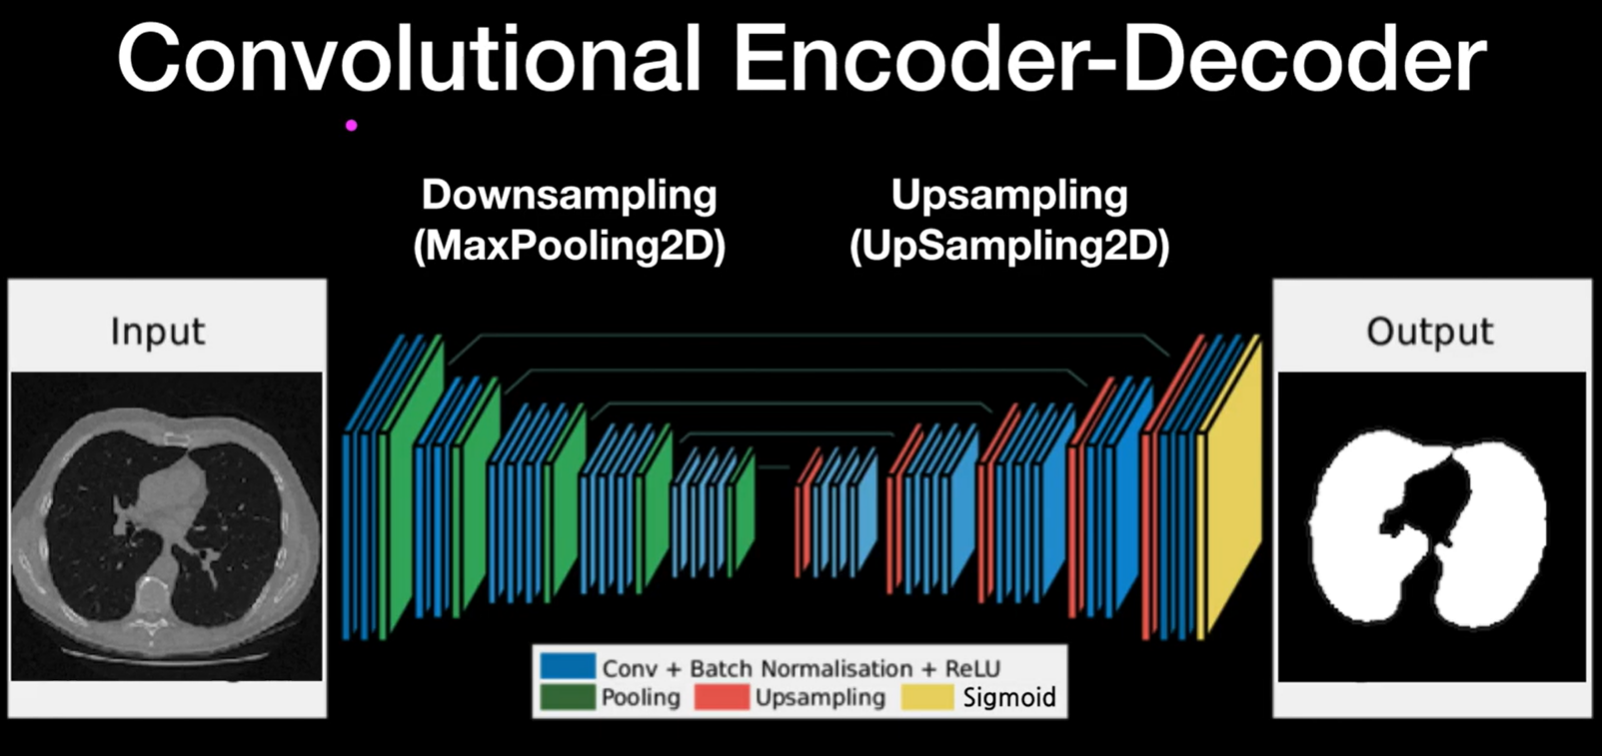

In [4]:
inputs = Input(shape=(256, 256, 1))

net = Conv2D(32, kernel_size=3, activation='relu', padding='same')(inputs)  # convolution
net = MaxPooling2D(pool_size=2, padding='same')(net)     # downsampling 2배만큼 줄임

net = Conv2D(64, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Conv2D(128, kernel_size=3, activation='relu', padding='same')(net)
net = MaxPooling2D(pool_size=2, padding='same')(net)

net = Dense(128, activation='relu')(net)      # 학습을 더 잘하기 위한 dense layer 추가

net = UpSampling2D(size=2)(net)     # upsampling 2배만큼 늘림 (input과 output을 같게 해줘야하니까)
net = Conv2D(128, kernel_size=3, activation='sigmoid', padding='same')(net)    # convolution

net = UpSampling2D(size=2)(net)
net = Conv2D(64, kernel_size=3, activation='sigmoid', padding='same')(net)

net = UpSampling2D(size=2)(net)
outputs = Conv2D(1, kernel_size=3, activation='sigmoid', padding='same')(net)    # output 1채널

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc', 'mse'])  # 0과1을 판단하니까 binary사용

model.summary()   # input과 output을 맞춰줌 (256x256) = convolutional encoder decoder 완성

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856 

# **Train**

In [5]:
# 모델 학습
# 100에폭, 배치사이즈 32

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, batch_size=32, callbacks=[
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose=1, mode='auto', min_lr=1e-05)
])


Epoch 1/100
8/8 [==============================] - 21s 1s/step - loss: 0.5576 - acc: 0.7522 - mse: 0.1789 - val_loss: 0.4838 - val_acc: 0.7419 - val_mse: 0.1584 - lr: 0.0010
Epoch 2/100
8/8 [==============================] - 3s 382ms/step - loss: 0.4595 - acc: 0.7522 - mse: 0.1501 - val_loss: 0.4464 - val_acc: 0.7419 - val_mse: 0.1505 - lr: 0.0010
Epoch 3/100
8/8 [==============================] - 3s 385ms/step - loss: 0.4206 - acc: 0.7503 - mse: 0.1402 - val_loss: 0.4146 - val_acc: 0.7446 - val_mse: 0.1381 - lr: 0.0010
Epoch 4/100
8/8 [==============================] - 3s 385ms/step - loss: 0.3909 - acc: 0.7637 - mse: 0.1299 - val_loss: 0.3761 - val_acc: 0.7764 - val_mse: 0.1247 - lr: 0.0010
Epoch 5/100
8/8 [==============================] - 3s 385ms/step - loss: 0.3853 - acc: 0.7619 - mse: 0.1303 - val_loss: 0.3658 - val_acc: 0.7611 - val_mse: 0.1222 - lr: 0.0010
Epoch 6/100
8/8 [==============================] - 3s 385ms/step - loss: 0.3528 - acc: 0.7792 - mse: 0.1180 - val_loss: 0.

# **Evaluation**

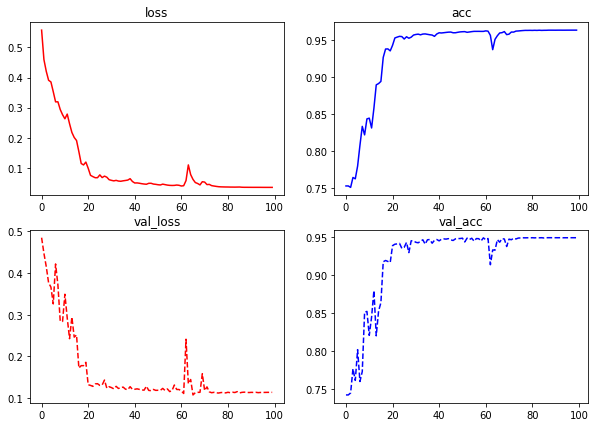

In [6]:
# 학습이 얼마나 잘 진행됐는지 그래프로 표현

fig, ax = plt.subplots(2, 2, figsize=(10, 7))

ax[0, 0].set_title('loss')
ax[0, 0].plot(history.history['loss'], 'r')
ax[0, 1].set_title('acc')
ax[0, 1].plot(history.history['acc'], 'b')

ax[1, 0].set_title('val_loss')
ax[1, 0].plot(history.history['val_loss'], 'r--')
ax[1, 1].set_title('val_acc')
ax[1, 1].plot(history.history['val_acc'], 'b--')

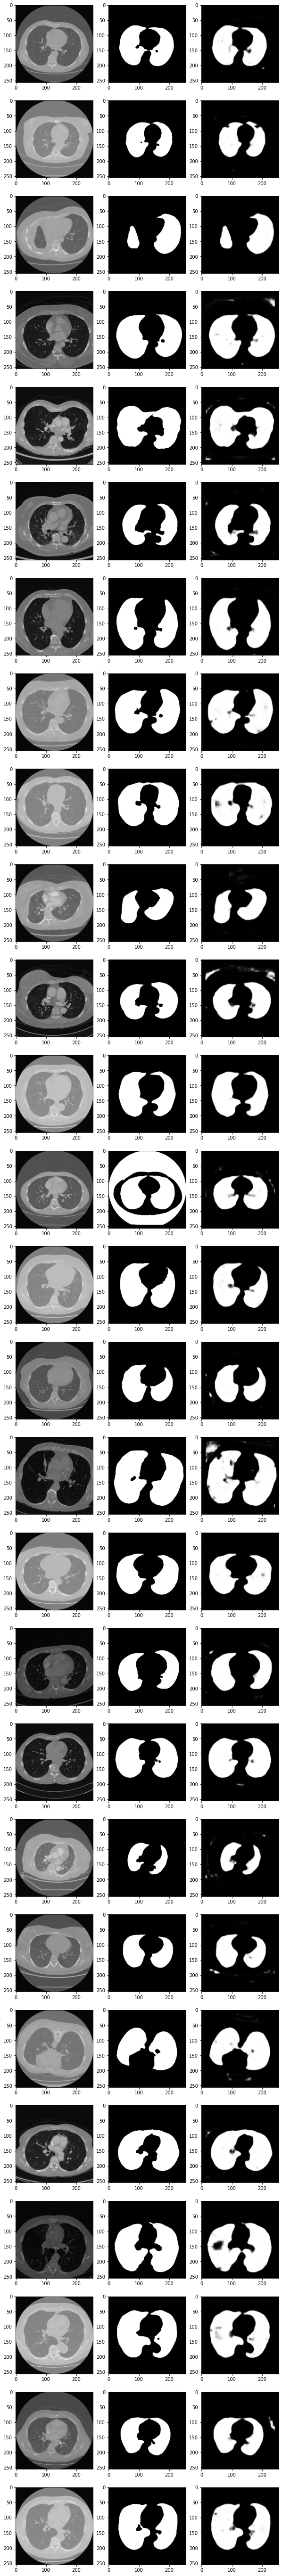

In [7]:
preds = model.predict(x_val)

fig, ax = plt.subplots(len(x_val), 3, figsize=(10, 100))

for i, pred in enumerate(preds):
    ax[i, 0].imshow(x_val[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_val[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')